# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy import stats

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = feat_info = pd.read_table('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [3]:
azdias.shape

(891221, 85)

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
ALTERSKATEGORIE_GROB,891221.0,2.777398,1.068775,1.0,2.0,3.0,4.0,9.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0
CJT_GESAMTTYP,886367.0,3.632838,1.595021,1.0,2.0,4.0,5.0,6.0
FINANZ_MINIMALIST,891221.0,3.074528,1.321055,1.0,2.0,3.0,4.0,5.0
FINANZ_SPARER,891221.0,2.821039,1.464749,1.0,1.0,3.0,4.0,5.0
FINANZ_VORSORGER,891221.0,3.401106,1.322134,1.0,3.0,3.0,5.0,5.0
FINANZ_ANLEGER,891221.0,3.033328,1.529603,1.0,2.0,3.0,5.0,5.0
FINANZ_UNAUFFAELLIGER,891221.0,2.874167,1.486731,1.0,2.0,3.0,4.0,5.0
FINANZ_HAUSBAUER,891221.0,3.075121,1.353248,1.0,2.0,3.0,4.0,5.0


In [7]:
azdias.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AGER_TYP,-1,-1,-1,2,-1,3,-1,-1,-1,-1,0,-1,-1,-1,-1,1,-1,-1,-1,-1
ALTERSKATEGORIE_GROB,2,1,3,4,3,1,2,1,3,3,3,2,3,1,3,4,1,2,2,3
ANREDE_KZ,1,2,2,2,1,2,2,1,1,2,2,1,1,2,1,2,2,1,2,1
CJT_GESAMTTYP,2,5,3,2,5,2,5,3,3,4,1,6,6,5,6,4,1,6,6,3
FINANZ_MINIMALIST,3,1,1,4,4,3,1,3,4,2,2,3,5,1,3,4,4,3,2,5
FINANZ_SPARER,4,5,4,2,3,1,5,3,4,4,2,4,3,4,4,1,3,4,4,2
FINANZ_VORSORGER,3,2,1,5,4,5,1,4,2,2,5,3,4,3,3,5,1,3,1,3
FINANZ_ANLEGER,5,5,2,2,1,2,5,1,4,3,3,5,2,5,5,1,4,5,5,1
FINANZ_UNAUFFAELLIGER,5,4,3,1,3,2,4,3,2,5,1,5,4,5,5,1,5,5,4,3
FINANZ_HAUSBAUER,3,5,5,2,2,5,3,2,2,4,5,3,1,2,3,4,1,3,1,1


In [8]:
# list of NA's by column

azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [9]:
# function to replace missing values


def nan_conversion(df, mapper, mapper_column_name, mapper_column_definition, non_numerical_indicators=[]):
    # For each mapper_df row definition
    for index, row in mapper.iterrows():
        # Omit rows with no NaNs or with lists without values
        if len(row[mapper_column_definition]) > 0 and row[mapper_column_definition] != ['']:
            try:
                # For each column definition
                # build a list of nan_indicators
                replace_mask = []
                for nan_indicator in row[mapper_column_definition]:
                    
                    if nan_indicator in non_numerical_indicators:
                        replace_mask.append(nan_indicator)
                    else:
                        replace_mask.append(int(nan_indicator))
                
                #print(replace_mask)
                # Replace masked values with NaN
                df[row[mapper_column_name]] = df[row[mapper_column_name]].replace(replace_mask, np.nan)
                
            except Exception as e:
                print('Exception: {} -> {} --> {}'.format(row[mapper_column_name], str(e), nan_indicator))
                continue
                
    return df

- 891221 rows, 85 columns which should also be count of features
- attributes don't mean much stand alone
- missing values

In [10]:
# shape of feature file

feat_info.shape

(85, 4)

In [11]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [12]:
feat_info.describe().T

,count,unique,top,freq
attribute,85,85,KBA05_ANTG3,1
information_level,85,9,person,43
type,85,5,ordinal,49
missing_or_unknown,85,9,[-1],26


In [13]:
#removal of brackets and making lists 
feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[').str.strip(']').str.split(',')

In [14]:
#if type(feat_info.missing_or_unknown[0]) == list:
#  or print (a) 
type(feat_info.missing_or_unknown[0])

list

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [15]:
print('Number of missing values before adjustment is {}'.format(azdias.isna().sum().sum()))

Number of missing values before adjustment is 4896838


In [16]:
# identify and replace missing or unknown with NaNs 

azdias = nan_conversion(azdias, feat_info, 'attribute', 'missing_or_unknown', non_numerical_indicators=['X', 'XX'])

In [17]:
print('Number of missing values after adjustment is {}'.format(azdias.isna().sum().sum()))

Number of missing values after adjustment is 8373929


In [18]:
# count of columns with high NaN

def nan_columns_alone(df):

    # Extract columns with NaNs
    columns_with_nans = df.isnull().sum()[df.isnull().sum() > 0]

    # Calculate percentage of NaN for each column
    dic_nan = {'sum': columns_with_nans.values, 'percent': np.round(columns_with_nans.values * 100 / df.shape[0], 2)}

    # Build a dataframe including only columns with NaNs
    df_nan = pd.DataFrame(data=dic_nan, index=columns_with_nans.index)

    # Sort by percentage
    df_nan.sort_values(by='percent', ascending=False, inplace=True)

    return df_nan

In [19]:
azdias_nan = nan_columns_alone(azdias)
azdias_nan

,sum,percent
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG3,133324,14.96


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [20]:
# Perform an assessment of how much missing data there is in each column of the dataset.

missing_by_column_percent =(azdias.isnull().sum()/len(azdias))*100

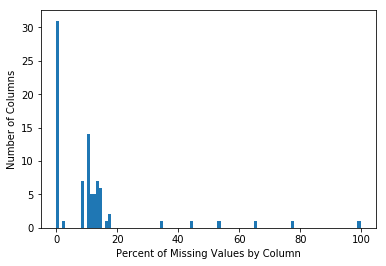

In [21]:
# Investigate patterns in the amount of missing data in each column.

plt.hist(missing_by_column_percent, bins=100)
plt.ylabel('Number of Columns')
plt.xlabel('Percent of Missing Values by Column')
plt.show()

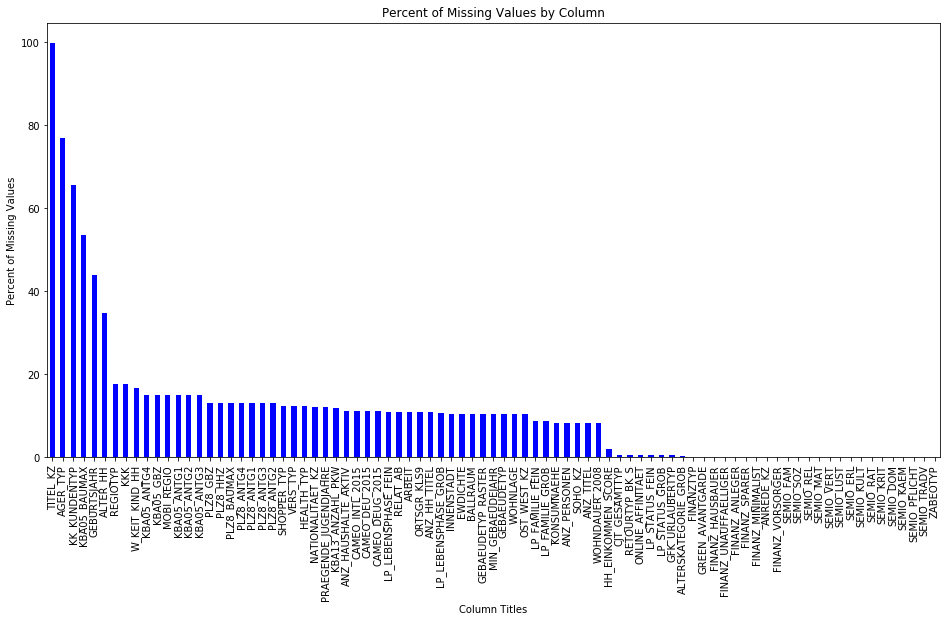

In [22]:
# Plot the percentage of missing values for each column
columns_sorted = missing_by_column_percent.sort_values(ascending=False)
plt.figure(figsize=(16,8))
plt.xlabel("Column Titles")
plt.ylabel("Percent of Missing Values")
plt.title("Percent of Missing Values by Column")
columns_sorted.plot.bar(color="blue");

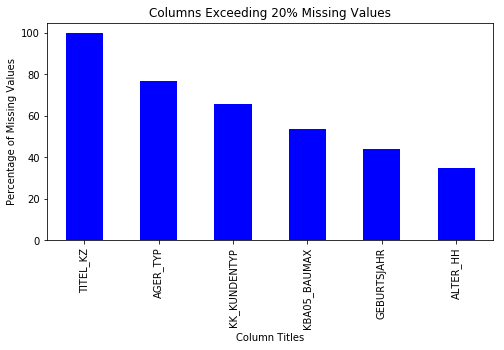

In [23]:
# Select the columns which have more than 20% missing values
columns_percent20 = missing_by_column_percent[missing_by_column_percent>20]
columns_percent20_list = columns_percent20.index.tolist()

# Plot it to see it better
plt.figure(figsize=(8,4))
plt.xlabel("Column Titles")
plt.ylabel("Percentage of Missing Values")
plt.title("Columns Exceeding 20% Missing Values")
plt.grid()
columns_percent20.sort_values(ascending=False).plot.bar(color="blue");

In [24]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)


# defined outlier columns above 30% missing values and drop  

drop_columns = azdias_nan[azdias_nan.percent > 30.].index.tolist()

 
azdias.drop(drop_columns, axis=1, inplace=True)


In [25]:
# Drop the corresponding columns from feat_info

feat_info = feat_info[~feat_info.attribute.isin(drop_columns)]
 

In [26]:
# check  remaining columns

azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [27]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 79 columns):
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          813429 non-null float64
LP_STATUS_FEIN           886367 non-null float64
LP_STATUS_GROB           

In [28]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]


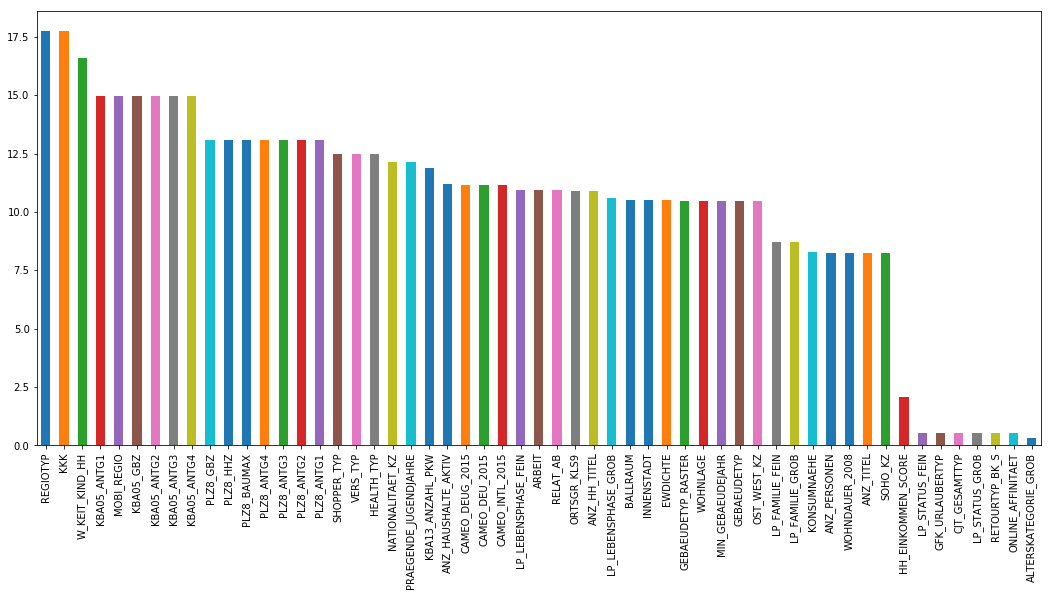

In [29]:
# investigate patterns in the amount of missing data in remaining columns

azdias_nan = nan_columns_alone(azdias)
azdias_nan.percent.plot.bar(figsize=(18, 8));

In [30]:
# generate attribute column 

feat_info.set_index('attribute', inplace=True, drop=False)

feat_info.head()

,attribute,information_level,type,missing_or_unknown
attribute,,,,
ALTERSKATEGORIE_GROB,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
ANREDE_KZ,ANREDE_KZ,person,categorical,"[-1, 0]"
CJT_GESAMTTYP,CJT_GESAMTTYP,person,categorical,[0]
FINANZ_MINIMALIST,FINANZ_MINIMALIST,person,ordinal,[-1]
FINANZ_SPARER,FINANZ_SPARER,person,ordinal,[-1]


In [31]:
# Add NaN information columns to feat_info
# by index / rows, for better columns understanding

feat_info = feat_info.join(azdias_nan)

# Sort by percentage
feat_info.sort_values(by='percent', ascending=False, inplace=True)

In [32]:
# check out missing data in features > 10 %

feat_info[feat_info.percent >= 10]

,attribute,information_level,type,missing_or_unknown,sum,percent
attribute,,,,,,
REGIOTYP,REGIOTYP,region_rr1,ordinal,"[-1, 0]",158064.0,17.74
KKK,KKK,region_rr1,ordinal,"[-1, 0]",158064.0,17.74
W_KEIT_KIND_HH,W_KEIT_KIND_HH,household,ordinal,"[-1, 0]",147988.0,16.61
KBA05_ANTG1,KBA05_ANTG1,microcell_rr3,ordinal,[-1],133324.0,14.96
MOBI_REGIO,MOBI_REGIO,region_rr1,ordinal,[],133324.0,14.96
KBA05_GBZ,KBA05_GBZ,microcell_rr3,ordinal,"[-1, 0]",133324.0,14.96
KBA05_ANTG2,KBA05_ANTG2,microcell_rr3,ordinal,[-1],133324.0,14.96
KBA05_ANTG3,KBA05_ANTG3,microcell_rr3,ordinal,[-1],133324.0,14.96
KBA05_ANTG4,KBA05_ANTG4,microcell_rr3,ordinal,[-1],133324.0,14.96


#### Discussion 1.1.2: Assess Missing Data in Each Column

#### 79 columns remain vs 85 originally

#### 6 columns to drop were identified based on the histogram and focusing on outlier columns with percent of missing data above 20%. 

The following columns must be dropped because of high missing values:'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'
 
In taking a closer look at these 6 columns they are not consistent they are scatted across multiple features.

- AGER_TYP: Best-ager typology
- GEBURTSJAHR: Year of birth
- TITEL_KZ: Academic title flag
- ALTER_HH: Birthdate of head of household
- KK_KUNDENTYP: Consumer pattern over past 12 months
- KBA05_BAUMAX: Most common building type within the microcell

Columns exceeding 10% missing data stretch across every type ( categorical, numeric, ordinal, etc) no pattern observed

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

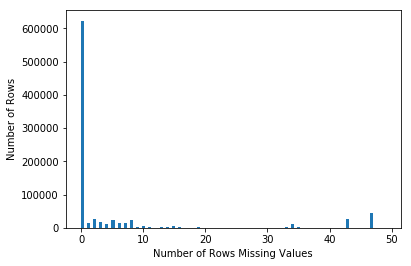

In [33]:
# How much data is missing in each row of the dataset?


missing_row =azdias.isnull().sum(axis=1)
plt.hist(missing_row, bins=100)
plt.ylabel('Number of Rows')
plt.xlabel('Number of Rows Missing Values')
plt.show()


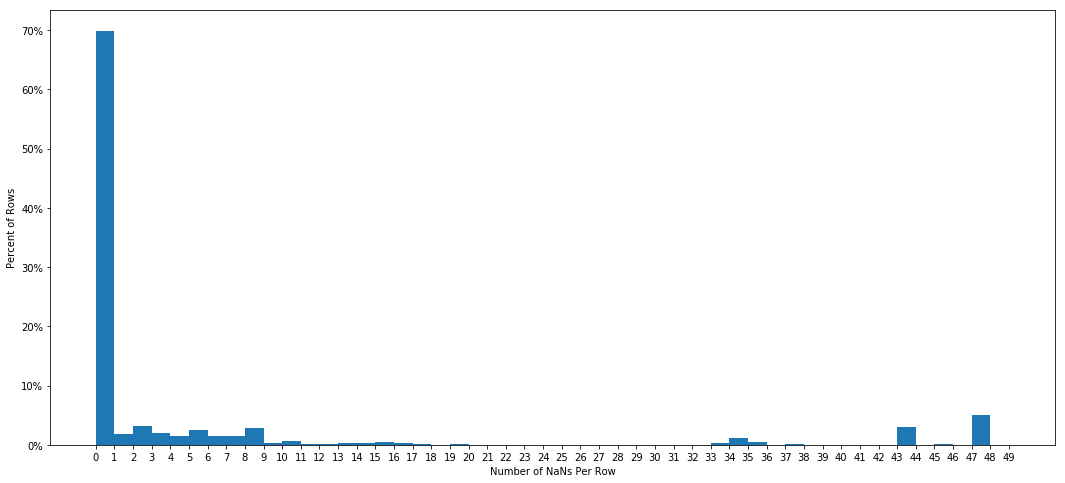

In [37]:
# visual by percent for better clarity

plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, 50, 1))
plt.xlabel('Number of NaNs Per Row')
plt.ylabel('Percent of Rows')

# Percent of observations in the Y axis
plt.hist(row_missing_data, weights=np.ones(len(row_missing_data)) / len(row_missing_data), bins=np.arange(0, 50, 1))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.show();

In [38]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Optimal threshold for splitting is greater than and less than 20 based on the distribution of missing values in the plot above

split_value = 20

low_missing_values = azdias[azdias.isnull().sum(axis=1) <= split_value]
high_missing_values = azdias[azdias.isnull().sum(axis=1) > split_value]

# check for healthy divide of dataset

print(low_missing_values.shape)
print(high_missing_values.shape)

(797426, 79)
(93795, 79)


In [39]:
columns_wout_missing_values = missing_by_column_percent[missing_by_column_percent==0].index.tolist()
columns_selected = columns_wout_missing_values[:5]
columns_selected

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER']

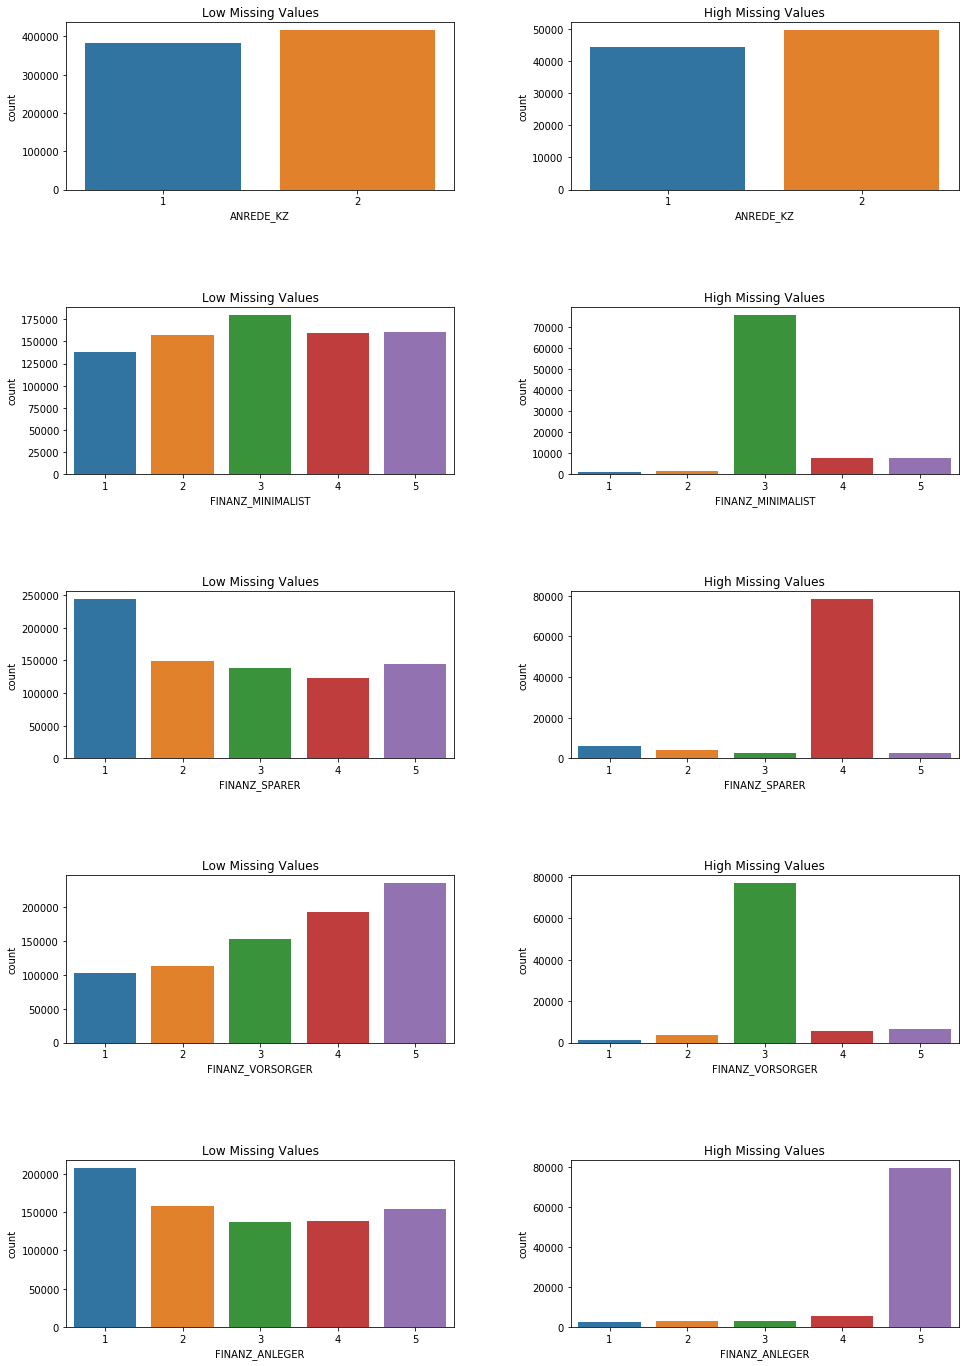

In [40]:
# visual of five columns based on amount of missing data

figure, axs = plt.subplots(nrows=len(columns_selected), ncols=2, figsize=(16,24))
figure.subplots_adjust(hspace=0.7, wspace=0.3)
for col in range(len(columns_selected)):
    sns.countplot(low_missing_values[columns_selected[col]], ax=axs[col][0])
    axs[col][0].set_title("Low Missing Values")

    sns.countplot(high_missing_values[columns_selected[col]], ax=axs[col][1])
    axs[col][1].set_title("High Missing Values")

#### Discussion 1.1.3: Assess Missing Data in Each Row

- Out of the 891221 rows, 268012 or 30% have missing data. 

- The rows with alot of missing data are not qualitatively different from the balance based on financial typography. 

-  FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER
    - Average and low income financial typography have high missing values vs total 
    - ANRED_KZ which is gender seems to be consistent with total
    
-  Total seems to skew toward low missing values in 1 which is financial typography very high


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [59]:
# How many features are there of each data type?

features = list(low_missing_values.columns)
feature_info_updated = feat_info[feat_info["attribute"].isin(features)]
feature_count = feature_info_updated["type"].value_counts()

for v in range(len(feature_count)):
    print("There are {} {} features.".format(feature_count[v], feature_count.index[v]))

There are 49 ordinal features.
There are 18 categorical features.
There are 6 mixed features.
There are 6 numeric features.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [60]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feat_info[feat_info.type == 'categorical'].attribute

print(categorical_features)

attribute
SHOPPER_TYP              SHOPPER_TYP
VERS_TYP                    VERS_TYP
NATIONALITAET_KZ    NATIONALITAET_KZ
CAMEO_DEUG_2015      CAMEO_DEUG_2015
CAMEO_DEU_2015        CAMEO_DEU_2015
GEBAEUDETYP              GEBAEUDETYP
OST_WEST_KZ              OST_WEST_KZ
LP_FAMILIE_FEIN      LP_FAMILIE_FEIN
LP_FAMILIE_GROB      LP_FAMILIE_GROB
SOHO_KZ                      SOHO_KZ
LP_STATUS_FEIN        LP_STATUS_FEIN
GFK_URLAUBERTYP      GFK_URLAUBERTYP
CJT_GESAMTTYP          CJT_GESAMTTYP
LP_STATUS_GROB        LP_STATUS_GROB
ANREDE_KZ                  ANREDE_KZ
FINANZTYP                  FINANZTYP
GREEN_AVANTGARDE    GREEN_AVANTGARDE
ZABEOTYP                    ZABEOTYP
Name: attribute, dtype: object


In [61]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feature_info_updated[feature_info_updated["type"]=="categorical"]["attribute"]

In [62]:
# categorical data split into buckets


features_binary = []
features_multilevel = []

for feature in categorical_features:
    if len(low_missing_values[feature].unique())==2:
        features_binary.append(feature)
    else:
        features_multilevel.append(feature)

print("Binary features are: {}.".format(", ".join(features_binary)))
print("\nMulti-level features are: {}.".format(", ".join(features_multilevel)))

Binary features are: OST_WEST_KZ, SOHO_KZ, ANREDE_KZ, GREEN_AVANTGARDE.

Multi-level features are: SHOPPER_TYP, VERS_TYP, NATIONALITAET_KZ, CAMEO_DEUG_2015, CAMEO_DEU_2015, GEBAEUDETYP, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, LP_STATUS_FEIN, GFK_URLAUBERTYP, CJT_GESAMTTYP, LP_STATUS_GROB, FINANZTYP, ZABEOTYP.


In [63]:
for col in features_binary:
    print(azdias[col].value_counts())

W    629528
O    168545
Name: OST_WEST_KZ, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
2    465305
1    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64


In [64]:
# standardize binary columns into 0 or 1
azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

In [65]:
for col in features_binary:
    print(azdias[col].value_counts())

1.0    629528
0.0    168545
Name: OST_WEST_KZ, dtype: int64
0.0    810834
1.0      6888
Name: SOHO_KZ, dtype: int64
1    465305
0    425916
Name: ANREDE_KZ, dtype: int64
0    715996
1    175225
Name: GREEN_AVANTGARDE, dtype: int64


In [66]:
# Do one-hot-encoding and remove reference columns

azdias = pd.get_dummies(azdias, columns=features_multilevel)

#### Discussion 1.2.1: Re-Encode Categorical Features

- There are 49 ordinal features.
- There are 18 categorical features.
- There are 6 mixed features.
- There are 6 numeric features.


- Converted binary columns to reflect 0 and 1
- Re-encoded values in 'OST_WEST_KZ' as numbers 
- Encode multi level features using one hot coding, get_dummies
- Categorical features are okay to keep, just need to assess the amount necessary for algorithm
- Need to address Mixed Type (next step*




#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [67]:
# Select mixed features names

mixed_features = feat_info[feat_info.type == 'mixed'].attribute
print(mixed_features)

attribute
PLZ8_BAUMAX                        PLZ8_BAUMAX
PRAEGENDE_JUGENDJAHRE    PRAEGENDE_JUGENDJAHRE
CAMEO_INTL_2015                CAMEO_INTL_2015
LP_LEBENSPHASE_FEIN        LP_LEBENSPHASE_FEIN
LP_LEBENSPHASE_GROB        LP_LEBENSPHASE_GROB
WOHNLAGE                              WOHNLAGE
Name: attribute, dtype: object


In [68]:
azdias[mixed_features].sample(5).T

,675456,534775,278654,158647,416949
PLZ8_BAUMAX,NaN,1,1,1,1
PRAEGENDE_JUGENDJAHRE,NaN,14,NaN,8,14
CAMEO_INTL_2015,NaN,14,43,51,51
LP_LEBENSPHASE_FEIN,NaN,30,NaN,21,14
LP_LEBENSPHASE_GROB,NaN,9,NaN,6,4
WOHNLAGE,NaN,3,3,5,3


In [69]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Generation 
generations = {0: [1, 2], # 40s
               1: [3, 4], # 50s
               2: [5, 6, 7], # 60s
               3: [8, 9], # 70s
               4: [10, 11, 12, 13], # 80s
               5:[14, 15]} # 90s

def classify_generation(value):
    try:
        for key, values in generations.items():
            if value in values:
                return key
    # In case value is NaN
    except ValueError:
        return np.nan
    
# Movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def classify_movement(value):
    try:
        if value in mainstream:
            return 1
        else:
            return 0
    # In case value is NaN
    except ValueError:
        return np.nan

In [70]:
# engineering generation column
azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)
#azdias.loc[:,'PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)

# engineering movement column
azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)
#azdias_new.loc[:,'PRAEGENDE_JUGENDJAHRE_MOV'] = azdias_new['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)

In [71]:
azdias.sample(15).T

,791432,806441,295902,7508,753495,551235,113445,614916,709064,837599,220259,799245,615748,707274,189260
ALTERSKATEGORIE_GROB,2,3,3,4,1,3,3,4,3,3,3,3,3,3,4
ANREDE_KZ,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0
FINANZ_MINIMALIST,2,2,3,5,3,5,5,2,3,5,5,5,5,2,5
FINANZ_SPARER,5,4,3,1,5,1,2,1,4,1,1,1,1,3,1
FINANZ_VORSORGER,2,1,4,5,1,5,4,5,1,5,5,5,5,3,5
FINANZ_ANLEGER,3,5,2,1,5,1,2,2,2,1,1,1,1,3,1
FINANZ_UNAUFFAELLIGER,4,4,2,2,3,2,2,1,4,2,1,2,2,1,3
FINANZ_HAUSBAUER,2,2,3,3,1,2,1,5,3,2,3,2,3,5,2
GREEN_AVANTGARDE,0,0,0,1,0,0,1,0,0,0,1,1,1,0,0
HEALTH_TYP,2,3,3,2,1,3,3,2,1,3,3,3,3,2,1


In [72]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.


# 1 is wealth
# 2 is life stage

# Wealth 
def classify_wealth(value):
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return first digit
        return int(str(value)[0])

# Life stage
def classify_lifestage(value):
    # In case value is NaN
    if pd.isnull(value):
        return np.nan
    else:
        # Return second digit
        return int(str(value)[1])


In [73]:
# engineering wealth column
azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(classify_wealth)

# engineering life stage column
azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(classify_lifestage)

In [74]:
azdias.sample(15).T

,323396,141337,776348,797227,528243,119133,341364,535528,321188,829302,500228,538981,216412,204348,105665
ALTERSKATEGORIE_GROB,2,4,2,1,3,3,3,4,3,2,3,1,1,1,3
ANREDE_KZ,1,1,1,1,1,0,1,1,0,0,1,1,1,0,0
FINANZ_MINIMALIST,1,5,1,1,2,3,3,5,5,5,1,1,1,1,3
FINANZ_SPARER,4,1,5,4,3,4,4,1,2,3,5,5,5,5,3
FINANZ_VORSORGER,2,5,2,2,4,3,3,5,4,1,1,2,2,3,4
FINANZ_ANLEGER,3,2,4,5,2,5,5,3,1,2,4,5,5,5,1
FINANZ_UNAUFFAELLIGER,5,1,4,4,2,5,5,3,3,5,3,3,3,5,2
FINANZ_HAUSBAUER,2,3,3,5,4,3,3,3,1,1,5,5,5,5,2
GREEN_AVANTGARDE,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
HEALTH_TYP,2,1,2,1,2,NaN,NaN,1,1,3,3,3,3,1,3


#### Discussion 1.2.2: Engineer Mixed-Type Features


- As highlighted, There were 6 mixed-type features in the dataset. After investigation, I engineered 4 new features, 2  PRAEGENDE_JUGENDJAHRE and 2 CAMEO_INTL_2015.  
    - new features are already ordinal

- Standardized binary columns into 0 or 1




In [75]:
# drop columns no longer needed

azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE',
                      'CAMEO_INTL_2015',
                      'PLZ8_BAUMAX',
                      'LP_LEBENSPHASE_FEIN',
                      'WOHNLAGE',
                      'REGIOTYP',
                      'KKK'], axis=1)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [76]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)


In [77]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
if 'NAN_NUM' in azdias.columns:
    azdias = azdias.drop(['NAN_NUM'], axis=1)

# Check
azdias.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 192 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(39), int64(23), uint8(130)
memory usage: 532.1 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [87]:
# clean function

def clean_data(azdias, feat_info, split_value):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame, feature info DataFrame, and split_value
    OUTPUT: Trimmed and cleaned demographics DataFrame and feature info DataFrame
    """
    
    # Remove brackets and split strings into lists
    # in feat_info.missing_or_unknown
    if type(feat_info.missing_or_unknown[0]) == str:
        feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.strip('[').str.strip(']').str.split(',')
    
    # Replace with NaNs all values in all columns of azdias as per mapping in feat_info
    azdias = nan_conversion(azdias, feat_info, 'attribute', 'missing_or_unknown', non_numerical_indicators=['X', 'XX'])

    azdias_nan = nan_columns_alone(azdias)

    # Drop the outlier columns
    drop_columns = azdias_nan[azdias_nan.percent > 30.].index.tolist()
    azdias.drop(drop_columns, axis=1, inplace=True)

    # Drop the corresponding columns from feat_info
    feat_info = feat_info[~feat_info.attribute.isin(drop_columns)]

    # In order to merge to dataframes by index we need to have indexes
    # as attributes in both dataframes
    feat_info.set_index('attribute', inplace=True, drop=False)

    # Add NaN information columns to feat_info
    # by index / rows, for better columns understanding
    #feat_info = feat_info.join(azdias_nan)
    
    # Examin numerical features
    df_num = azdias.select_dtypes(include = ['float64', 'int64'])
    
    # Remove highly correlated numerical features
    #columns_to_drop = correlated_columns_to_drop(df_num, 0.95)
    azdias.drop(drop_columns, axis=1, inplace=True)
    feat_info = feat_info[~feat_info.attribute.isin(drop_columns)]
    
    missing_data_by_row = azdias.isnull().sum(axis=1)
    
    # Add information about number of NaN for each row to the master dataset
    azdias = azdias.assign(NAN_NUM=pd.Series(missing_data_by_row.values))
    
    high_missing_values = azdias[azdias.NAN_NUM >= split_value].copy()
    low_missing_values = azdias[azdias.NAN_NUM < split_value].copy()

    # Remove all rows with missing values above split_value
    #azdias = azdias[azdias.NAN_NUM < split_value]
    
    # Select categorical features names
    categorical_features = feat_info[feat_info.type == 'categorical'].attribute

    # Split categorical variables into binary or multi buckets
    features_binary = []
    features_multi = []
    for feature in categorical_features:
        if azdias[feature].nunique() > 2:
            features_multi.append(feature)
        else:
            features_binary.append(feature)

    # Standardize binary columns into 0 or 1
    azdias['VERS_TYP'].replace([2.0, 1.0], [1, 0], inplace=True)
    azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
    azdias['ANREDE_KZ'].replace([2, 1], [1, 0], inplace=True)

    # Do one-hot-encoding and remove reference columns
    azdias = pd.get_dummies(azdias, columns=features_multi)

    # Select mixed features names
    mixed_features = feat_info[feat_info.type == 'mixed'].attribute

    # Engineer features
    azdias['PRAEGENDE_JUGENDJAHRE_GEN'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_generation)
    azdias['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(classify_movement)
    azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(classify_wealth)
    azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(classify_lifestage)
    
    # the listed drop columns here are not consistent with actual dropped per cell above
    #Remove unneeded and the rest of mixed columns (as per instruction above)
    azdias = azdias.drop(['PRAEGENDE_JUGENDJAHRE',
                          'CAMEO_INTL_2015',
                          'PLZ8_BAUMAX',
                          'LP_LEBENSPHASE_FEIN',
                          'WOHNLAGE'], axis=1)
    

    azdias.drop(drop_columns, axis=1, inplace=True)
    feat_info = feat_info[~feat_info.attribute.isin(drop_columns)]

    # Remove NAN_NUM column
    azdias = azdias.drop(['NAN_NUM'], axis=1)
    
    return azdias, feat_info, high_missing_values, low_missing_values
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [79]:
azdias_clean = azdias.dropna()
azdias_clean.shape[0]

650866

In [80]:
# double checking nan removal

azdias_nan2 = nan_columns_alone(azdias_clean)
azdias_nan2

,sum,percent


In [81]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.


# use SKlearn SimpleImputer to impute NaN values in dataset with "most_frequent" value

fill_missing = Imputer(strategy='most_frequent')
azdias_clean_imputed = pd.DataFrame(fill_missing.fit_transform(azdias_clean))

In [91]:
azdias_clean_imputed.columns = azdias_clean.columns
azdias_clean_imputed.index = azdias_clean.index

In [92]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler() 
azdias_clean_scaled = scaler.fit_transform(azdias_clean_imputed)

In [93]:
# final df 
azdias_clean_scaled = pd.DataFrame(azdias_clean_scaled, columns=list(azdias_clean_imputed))

### Discussion 2.1: Apply Feature Scaling

- Removed rows with NaNs:  

- The data could vary in measurement based on the content of the column, so it made the most sense to use 
    the contentof that column via the frequent value in order to fill in values
    
    - Replaced missing value with Imputer object (most frequent value)
    
- Because the data has a large variety of ranges, and the units could vary based on the content of the column, 
    standard scaler was the best use as it reduces the scale and range of data.
    - this also improves processing speed
    
    -Scaled data using standard scaler which is mean of 0 and standard deviation of 1
    

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [94]:
# Apply PCA to the data.

pca = PCA()
pca.fit(azdias_clean_scaled)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

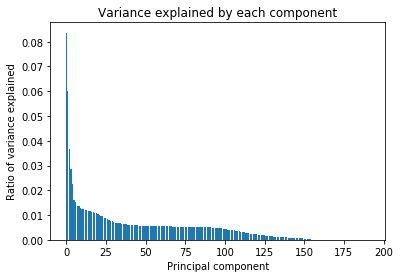

In [95]:
# Investigate the variance accounted for by each principal component.

plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

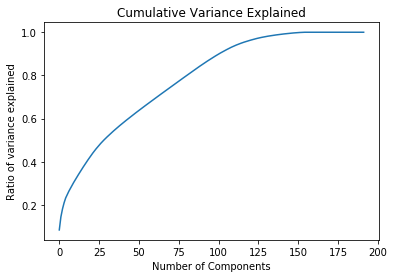

In [96]:
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), '-')
plt.title("Cumulative Variance Explained")
plt.xlabel("Number of Components")
plt.ylabel("Ratio of variance explained")
plt.show()

In [97]:
# in taking a look at how many components explain variance, 90 seems good since it explains 84% of variance

for i in np.arange(10, 91, 10):
    print('{} components explain {} of variance.'.format(i, pca.explained_variance_ratio_[:i].sum()))

10 components explain 0.3033010565506195 of variance.
20 components explain 0.41897829489463384 of variance.
30 components explain 0.5076751814978221 of variance.
40 components explain 0.5738085796830621 of variance.
50 components explain 0.6321549742130133 of variance.
60 components explain 0.687298689903081 of variance.
70 components explain 0.7412089676517711 of variance.
80 components explain 0.794529546520367 of variance.
90 components explain 0.8468732678646492 of variance.


In [98]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_90 = PCA(n_components=90)

azdias_pca = pca_90.fit_transform(azdias_clean_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

- 90 features provide explanation for a high number of variances that explain principal components as shown by the plot above
- takes features to almost half




In [ ]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [99]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def pca_weights(pca, i):
    df = pd.DataFrame(pca.components_, columns=list(azdias_clean_scaled.columns))
    weights = df.iloc[i].sort_values(ascending=False)
    return weights

In [100]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_0 = pca_weights(pca_90, 0)
print (pca_weight_0)

#pca_weight_0 = pca_weights(pca_90, 0)
#print (pca_weight_0)

LP_STATUS_GROB_1.0           0.191877
HH_EINKOMMEN_SCORE           0.181781
CAMEO_INTL_2015_WEALTH       0.180513
PLZ8_ANTG3                   0.177422
PLZ8_ANTG4                   0.171482
ORTSGR_KLS9                  0.149249
EWDICHTE                     0.147603
FINANZ_HAUSBAUER             0.141034
LP_STATUS_FEIN_1.0           0.127471
KBA05_ANTG4                  0.125546
PLZ8_ANTG2                   0.120615
FINANZ_SPARER                0.119692
KBA05_ANTG3                  0.116085
ANZ_HAUSHALTE_AKTIV          0.114474
FINANZTYP_1                  0.111658
LP_STATUS_FEIN_2.0           0.111474
ARBEIT                       0.110688
CAMEO_DEUG_2015_9            0.109801
PRAEGENDE_JUGENDJAHRE_MOV    0.106630
RELAT_AB                     0.102525
LP_FAMILIE_FEIN_1.0          0.097586
LP_FAMILIE_GROB_1.0          0.097586
CAMEO_DEUG_2015_8            0.090605
SEMIO_PFLICHT                0.086460
PRAEGENDE_JUGENDJAHRE_GEN    0.082156
SEMIO_REL                    0.081256
ZABEOTYP_5  

In [101]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_1 = pca_weights(pca_90, 1)
print (pca_weight_1)

ALTERSKATEGORIE_GROB         0.231436
FINANZ_VORSORGER             0.211148
ZABEOTYP_3                   0.198892
SEMIO_ERL                    0.183182
SEMIO_LUST                   0.160522
RETOURTYP_BK_S               0.156684
W_KEIT_KIND_HH               0.130895
CJT_GESAMTTYP_2.0            0.103869
LP_STATUS_FEIN_1.0           0.098206
FINANZTYP_5                  0.093034
FINANZ_HAUSBAUER             0.089642
FINANZTYP_2                  0.083564
SEMIO_KRIT                   0.082317
FINANZ_MINIMALIST            0.078905
SHOPPER_TYP_3.0              0.074138
LP_FAMILIE_GROB_1.0          0.073442
LP_FAMILIE_FEIN_1.0          0.073442
PLZ8_ANTG3                   0.071038
CJT_GESAMTTYP_1.0            0.067189
EWDICHTE                     0.067128
PLZ8_ANTG4                   0.066526
ORTSGR_KLS9                  0.066097
NATIONALITAET_KZ_1.0         0.065001
FINANZTYP_6                  0.064515
CAMEO_INTL_2015_WEALTH       0.061406
SEMIO_KAEM                   0.059578
GFK_URLAUBER

In [102]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_2= pca_weights(pca_90, 2)
print (pca_weight_2)

SEMIO_VERT                   0.321851
SEMIO_FAM                    0.259519
SEMIO_SOZ                    0.257858
SEMIO_KULT                   0.248257
FINANZTYP_5                  0.135016
FINANZ_MINIMALIST            0.131245
SHOPPER_TYP_0.0              0.126057
SEMIO_REL                    0.120775
ZABEOTYP_1                   0.116122
RETOURTYP_BK_S               0.084395
SEMIO_MAT                    0.080530
GREEN_AVANTGARDE             0.073073
W_KEIT_KIND_HH               0.071375
EWDICHTE                     0.062244
ORTSGR_KLS9                  0.061451
LP_STATUS_GROB_5.0           0.051591
LP_STATUS_FEIN_10.0          0.051591
ZABEOTYP_6                   0.049778
FINANZ_VORSORGER             0.049646
PLZ8_ANTG4                   0.046535
PLZ8_ANTG3                   0.045933
SHOPPER_TYP_1.0              0.044856
LP_STATUS_FEIN_1.0           0.043244
LP_STATUS_FEIN_3.0           0.042637
PLZ8_ANTG2                   0.033595
RELAT_AB                     0.033287
SEMIO_LUST  

### Discussion 2.3: Interpret Principal Components

#### First component 

##### Top
    - All surround wealth or income  
    
LP_STATUS_GROB_1.0           0.191877
HH_EINKOMMEN_SCORE           0.181781
CAMEO_INTL_2015_WEALTH       0.180513

##### Bottom
    - Non wealth inclined, regional & microcell

KBA05_ANTG1                 -0.190539
FINANZ_MINIMALIST           -0.190874
MOBI_REGIO                  -0.203307


#### Second Component

##### Top 
    - Spans across wealth, income or age

ALTERSKATEGORIE_GROB         0.231436
FINANZ_VORSORGER             0.211148
ZABEOTYP_3                   0.198892

##### Bottom
    - Includes personality typology
    
SEMIO_REL                   -0.218607
FINANZ_SPARER               -0.220294
PRAEGENDE_JUGENDJAHRE_GEN   -0.234144


#### Third Component

##### Top
    - Personality typology dreamers, family & social,

SEMIO_VERT                   0.321851
SEMIO_FAM                    0.259519
SEMIO_SOZ                    0.257859

##### Bottom
    - Personality typology dominant, combative & gender
    
SEMIO_DOM                   -0.283270
SEMIO_KAEM                  -0.315396
ANREDE_KZ                   -0.345548





## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [103]:
# generating a toy dataset with 1/4 of the values 

azdias_pca_sample = azdias_pca[np.random.choice(azdias_pca.shape[0], int(azdias_pca.shape[0]*0.25), replace=False)]
azdias_pca_sample 

array([[-1.94159201, -3.18307052, -4.09638013, ..., -2.38815829,
        -0.62798923, -1.65868696],
       [ 2.81305456, -4.90819905,  2.60884665, ...,  0.71303613,
        -0.05718002, -1.23559274],
       [-3.56904255,  2.84066791, -1.42167661, ...,  1.2972768 ,
        -1.14431312,  0.1282493 ],
       ..., 
       [-0.16379504, -1.91311138, -1.47358295, ..., -2.15576771,
        -2.08664201, -0.43386893],
       [-3.09932365, -1.51114626,  2.68756066, ..., -0.00702908,
        -0.1406345 , -0.76561098],
       [-3.11818232, -0.28448797,  1.21880872, ..., -0.46577891,
        -0.90828869,  0.48803696]])

In [78]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    

sse = [] # Sum of Squared Errors
k_range = np.arange(10, 31)

for k in k_range:
    kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(azdias_pca_sample)
    score = np.abs(kmeans.score(azdias_pca_sample))
    sse.append(score)
    print('Clustering done for {} k, with SSE {}'.format(k, score))    
    

Clustering done for 10 k, with SSE 20776378.500540793
Clustering done for 11 k, with SSE 20577400.394289404
Clustering done for 12 k, with SSE 20220476.10805584
Clustering done for 13 k, with SSE 20228547.612377964
Clustering done for 14 k, with SSE 20111564.944174483
Clustering done for 15 k, with SSE 19973838.820467625
Clustering done for 16 k, with SSE 19847268.762594398
Clustering done for 17 k, with SSE 19662315.11199461
Clustering done for 18 k, with SSE 19499922.290896904
Clustering done for 19 k, with SSE 19452776.323672626
Clustering done for 20 k, with SSE 19392606.897406843
Clustering done for 21 k, with SSE 19220466.70452471
Clustering done for 22 k, with SSE 19110640.257542975
Clustering done for 23 k, with SSE 18973010.603990242
Clustering done for 24 k, with SSE 18870627.623621013
Clustering done for 25 k, with SSE 18758956.77202259
Clustering done for 26 k, with SSE 18606351.88939433
Clustering done for 27 k, with SSE 18499924.813073307
Clustering done for 28 k, with SS

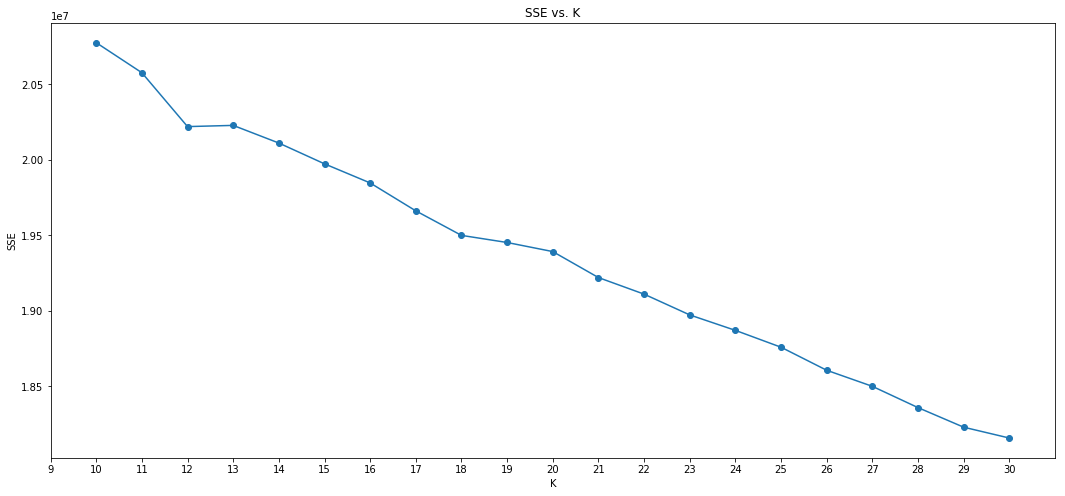

In [79]:
# Investigate the change in within-cluster distance across number of clusters.
 

plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.plot(k_range, sse, linestyle='-', marker='o');

In [80]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

k = 12
kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(azdias_pca)
population_clusters = kmeans.predict(azdias_pca)


### Discussion 3.1: Apply Clustering to General Population

I will use 12 to create the number of clusters and segment the population: 
    - Elbow method to establish when the line starts flattening out which seems to occur at 12


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [83]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [84]:
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [88]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean, feat_info_clean, cust_high_missing_values_clean, cust_low_missing_values_clean = clean_data(customers, feat_info, split_value)

Exception: REGIOTYP -> 'REGIOTYP' --> 0
Exception: KKK -> 'KKK' --> 0


In [89]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 195 entries, AGER_TYP to CAMEO_INTL_2015_LIFESTAGE
dtypes: float64(43), int64(25), uint8(127)
memory usage: 122.6 MB


In [104]:
for column in azdias_clean_scaled.columns:
    if column not in customers_clean.columns:
        print(column)

VERS_TYP_0.0
VERS_TYP_1.0
GEBAEUDETYP_5.0


In [105]:
customers_clean['GEBAEUDETYP_5.0' ] = 0
customers_clean['VERS_TYP_1.0' ] = 0
customers_clean['VERS_TYP_0.0' ] = 0

In [106]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 198 entries, AGER_TYP to VERS_TYP_0.0
dtypes: float64(43), int64(28), uint8(127)
memory usage: 127.0 MB


In [107]:
# double check after running again

difference_list = [item for item in customers_clean if item not in azdias_clean_scaled]

In [108]:
difference_list

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'VERS_TYP', 'ALTER_HH', 'KBA05_BAUMAX']

In [109]:
for col in difference_list:
    customers_clean.drop(col, axis=1, inplace=True)

In [110]:
# checkpoint final customers df after assessing variances to azdias columns

customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Columns: 192 entries, ALTERSKATEGORIE_GROB to VERS_TYP_0.0
dtypes: float64(39), int64(26), uint8(127)
memory usage: 118.3 MB


In [111]:
# drop NaNs using imputer from demographics data

customers_clean = fill_missing.transform(customers_clean)


In [96]:
# apply scaler from demographic data

customers_clean_scaled = scaler.transform(customers_clean)

In [97]:
# apply pcs from demographics data

customers_pca = pca_90.transform(customers_clean_scaled)

In [98]:
# apply clustering 

customer_clusters = kmeans.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'Population Clusters')

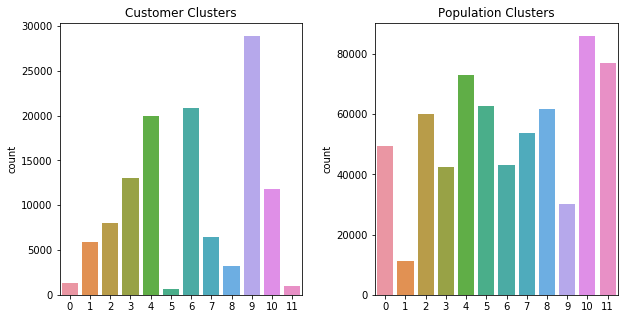

In [99]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,5))
figure.subplots_adjust(hspace = 1, wspace=.3)

sns.countplot(customer_clusters, ax=axs[0])
axs[0].set_title('Customer Clusters')
sns.countplot(population_clusters, ax=axs[1])
axs[1].set_title('Population Clusters')

In [101]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

centroid_9 = scaler.inverse_transform(pca_90.inverse_transform(kmeans.cluster_centers_[9]))

In [102]:
overrepresented_c = pd.Series(data = centroid_9, index = customers_clean.columns)

In [103]:
overrepresented_c

ALTERSKATEGORIE_GROB         3.010108
ANREDE_KZ                    0.415956
FINANZ_MINIMALIST            3.887313
FINANZ_SPARER                2.200572
FINANZ_VORSORGER             3.699714
FINANZ_ANLEGER               2.468098
FINANZ_UNAUFFAELLIGER        2.348479
FINANZ_HAUSBAUER             2.538348
GREEN_AVANTGARDE             0.482279
HEALTH_TYP                   2.228536
LP_LEBENSPHASE_GROB          7.815280
RETOURTYP_BK_S               3.478248
SEMIO_SOZ                    4.313997
SEMIO_FAM                    4.041064
SEMIO_REL                    3.638513
SEMIO_MAT                    3.746273
SEMIO_VERT                   4.795666
SEMIO_LUST                   4.725248
SEMIO_ERL                    4.620415
SEMIO_KULT                   4.207379
SEMIO_RAT                    3.563032
SEMIO_KRIT                   4.140556
SEMIO_DOM                    4.439859
SEMIO_KAEM                   3.847688
SEMIO_PFLICHT                3.747684
SEMIO_TRADV                  3.540955
SOHO_KZ     

In [104]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

centroid_10 = scaler.inverse_transform(pca_90.inverse_transform(kmeans.cluster_centers_[10]))

In [105]:
underrepresented_c = pd.Series(data = centroid_10, index = customers_clean.columns)

In [106]:
underrepresented_c

ALTERSKATEGORIE_GROB         3.229994
ANREDE_KZ                    0.044078
FINANZ_MINIMALIST            3.187404
FINANZ_SPARER                1.984984
FINANZ_VORSORGER             4.209539
FINANZ_ANLEGER               1.553552
FINANZ_UNAUFFAELLIGER        1.695527
FINANZ_HAUSBAUER             3.591839
GREEN_AVANTGARDE             0.081942
HEALTH_TYP                   2.355842
LP_LEBENSPHASE_GROB          3.597951
RETOURTYP_BK_S               4.530491
SEMIO_SOZ                    5.337625
SEMIO_FAM                    5.258835
SEMIO_REL                    3.931477
SEMIO_MAT                    4.249716
SEMIO_VERT                   5.795609
SEMIO_LUST                   4.847309
SEMIO_ERL                    4.124022
SEMIO_KULT                   5.145304
SEMIO_RAT                    2.752061
SEMIO_KRIT                   3.760925
SEMIO_DOM                    3.430301
SEMIO_KAEM                   2.952695
SEMIO_PFLICHT                3.488988
SEMIO_TRADV                  3.098921
SOHO_KZ     

### Discussion 3.3: Compare Customer Data to Demographics Data

### overrepresented people in customer data vs population from cluster 9:

LP_LEBENSPHASE_GROB          7.815280
SEMIO_VERT                   4.795666
SEMIO_LUST                   4.725248

- LP_LEBENSPHASE_GROB represents life stage of customer population that is single earners of advanced age nearing retirement even based on the value being 7.5 
- SEMIO_VERT is a dreamer while SEMIO_LUST is sensual minded personality typology with very low affinity
        - Maybe those who are near retirement could have more time and thus take advantage of reading mailers and ordering from the mail order company.
         - The semio lust personality is also an indicator as these have low affinity, may be home more.
         - Generally, these categories would be popular and a good target as they seem to have a captive audience for shopping from home via mailers.

### underrepresented people in customer data vs population from cluster 10:

INANZ_VORSORGER              4.209539
SEMIO_KULT                   5.145304

- INANZ_VORSORGER is an investor, possibly underrepresented due to low impulsive spending or more saving activies. 
- SEMIO_KULT is a culturally minded personality type is average and thus under represented.
        - A few others rose to the top around low income, or high investors which would 
        not be popular with the 
        mail-order company possibly because they don't have the discretionary funds or rather use them for other 
        things that have return on investment.



#### Additional Resources 
- https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35
- https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
- https://realpython.com/k-means-clustering-python/#:~:text=The%20SSE%20is%20defined%20as,try%20to%20minimize%20this%20value.
- https://www.scitepress.org/Papers/2019/99084/99084.pdf
- https://www.tutorialsteacher.com/python/python-user-defined-function
- https://www.analyticsvidhya.com/blog/2021/04/difference-between-fit-transform-fit_transform-methods-in-scikit-learn-with-python-code/


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.